In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from node2vec import Node2Vec


In [2]:
# !pip install node2vec

In [3]:
# Load the CSV file
file_path = "/content/employee_skills_ratings_V3.csv"
data = pd.read_csv(file_path)

In [4]:
data

,Employee ID,Department,ML,DL,Python,Statistics,Data Wrangling,R,Java,C++,...,Analytics,Social Media,Brand Management,Market Research,Accounting,Financial Analysis,Excel,Budgeting,Taxation,Investment Analysis
0,1,Marketing,0,0,0,0,0,0,0,0,...,7,10,3,7,0,0,0,0,0,0
1,2,Human Resources,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Finance,0,0,0,0,0,0,0,0,...,0,0,0,0,2,8,6,2,5,1
3,4,Marketing,0,0,0,0,0,0,0,0,...,9,1,10,3,0,0,0,0,0,0
4,5,Marketing,0,0,0,0,0,0,0,0,...,9,3,5,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,Marketing,0,0,0,0,0,0,0,0,...,9,1,6,7,0,0,0,0,0,0
146,147,Human Resources,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
147,148,Marketing,0,0,0,0,0,0,0,0,...,10,9,3,4,0,0,0,0,0,0
148,149,Data Science,10,6,2,7,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# import pandas as pd
from collections import defaultdict

# Define the department-specific skills mapping
department_skills = {
    "Finance": {"Financial Analysis", "Excel", "Accounting","Budgeting" ,"Taxation","Investment Analysis"},
    "Marketing": {"SEO", "Content Creation", "Social Media", "Brand Management", "Market Research","Analytics"},
    "Data Science": {"Python", "ML","DL", "Statistics","Data Wrangling","R"},
    "Human Resources":{"Recruitment","Training","Communication", "Conflict Resolution", "Employee Engagement","HR Policies"},
"Software Engineering":{"Python","Java", "C++","Algorithms","Data Structures","Git"}
}

average_skill_ratings = {}

for department, skills in department_skills.items():
    department_data = data[data["Department"] == department]

    average_ratings = {}
    for skill in skills:
        non_zero_ratings = department_data[skill][department_data[skill] > 0]
        if not non_zero_ratings.empty:
            average_ratings[skill] = np.round(non_zero_ratings.mean())
        else:
            average_ratings[skill] = 0

    average_skill_ratings[department] = average_ratings


In [6]:
average_skill_ratings

{'Finance': {'Investment Analysis': 5.0,
  'Taxation': 6.0,
  'Excel': 4.0,
  'Accounting': 4.0,
  'Financial Analysis': 6.0,
  'Budgeting': 5.0},
 'Marketing': {'Social Media': 5.0,
  'Brand Management': 5.0,
  'Analytics': 6.0,
  'Market Research': 6.0,
  'SEO': 6.0,
  'Content Creation': 6.0},
 'Data Science': {'DL': 5.0,
  'R': 6.0,
  'ML': 6.0,
  'Statistics': 6.0,
  'Python': 5.0,
  'Data Wrangling': 5.0},
 'Human Resources': {'Recruitment': 6.0,
  'HR Policies': 5.0,
  'Training': 5.0,
  'Communication': 6.0,
  'Employee Engagement': 6.0,
  'Conflict Resolution': 6.0},
 'Software Engineering': {'Algorithms': 6.0,
  'Java': 6.0,
  'Data Structures': 5.0,
  'C++': 6.0,
  'Python': 5.0,
  'Git': 5.0}}

Best fit department for the candidate: Data Science
Matching skills: {'ML': 7, 'Python': 6}
Missing skills: {'DL': 5.0, 'R': 6.0, 'Data Wrangling': 5.0}
Skills to improve: {'Statistics': 'Current: 3, Required: 6.0'}


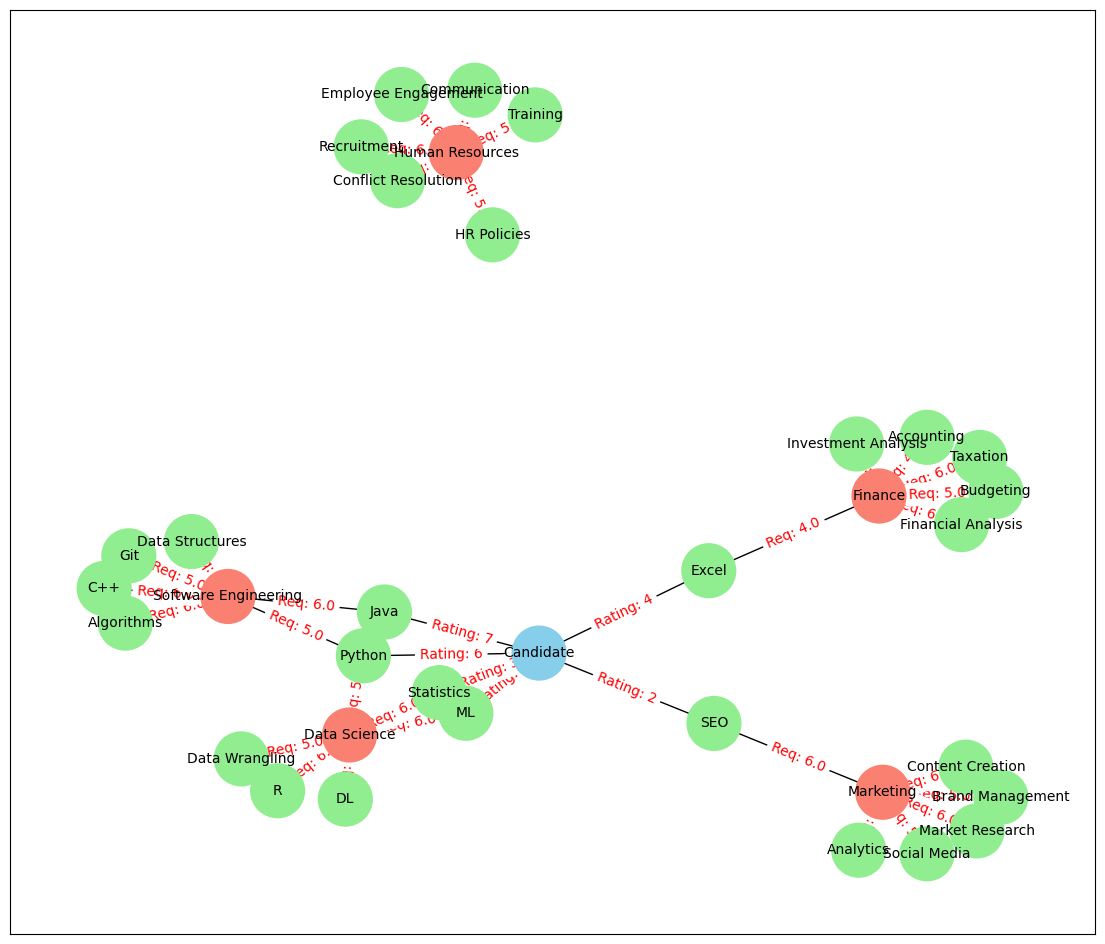

In [7]:
# Step 1: Create the Knowledge Graph

def create_knowledge_graph(department_skills, average_skill_ratings, candidate_skills):
    G = nx.Graph()

    # Add Department nodes
    for department in average_skill_ratings:
        G.add_node(department, type='Department')

    # Add Skill nodes
    for department, skills in department_skills.items():
        for skill in skills:
            if skill not in G.nodes:
                G.add_node(skill, type='Skill')

    # Add edges for department skill requirements
    for department, skill_ratings in average_skill_ratings.items():
        for skill, rating in skill_ratings.items():
            if rating > 0:
                G.add_edge(department, skill, relationship='NEEDS_SKILL', required_rating=rating)

    # Add Candidate node and their skill ratings
    candidate_node = 'Candidate'
    G.add_node(candidate_node, type='Candidate')
    for skill, rating in candidate_skills.items():
        if skill in G.nodes:
            G.add_edge(candidate_node, skill, relationship='HAS_SKILL', rating=rating)

    return G

# Step 2: Evaluate Fit Using the Knowledge Graph

def evaluate_fit_with_graph(G, department_skills, candidate_node='Candidate'):
    best_department = None
    best_match_score = float('-inf')
    best_fit_details = {}

    # Iterate over departments to evaluate fit
    for department in [n for n, d in G.nodes(data=True) if d['type'] == 'Department']:
        matching_skills = {}
        missing_skills = {}
        skills_to_improve = {}

        # Get the skills required by the department
        required_skills = {neighbor: G.edges[department, neighbor]['required_rating']
                           for neighbor in G.neighbors(department) if G.nodes[neighbor]['type'] == 'Skill'}

        # Compare with candidate's skills
        for skill, required_rating in required_skills.items():
            if G.has_edge(candidate_node, skill):
                candidate_rating = G.edges[candidate_node, skill]['rating']
                if candidate_rating >= required_rating:
                    matching_skills[skill] = candidate_rating
                else:
                    skills_to_improve[skill] = (candidate_rating, required_rating)
            else:
                missing_skills[skill] = required_rating

        # Calculate match score
        match_score = len(matching_skills) - (len(skills_to_improve) + len(missing_skills))

        if match_score > best_match_score:
            best_match_score = match_score
            best_department = department
            best_fit_details = {
                "matching_skills": matching_skills,
                "missing_skills": missing_skills,
                "skills_to_improve": skills_to_improve
            }

    return best_department, best_fit_details

# Step 3: Visualize the Knowledge Graph

def visualize_graph(G):
    plt.figure(figsize=(14, 12))

    # Define positions using spring layout
    pos = nx.spring_layout(G, seed=42)

    # Define colors based on node types
    color_map = {'Department': 'salmon', 'Skill': 'lightgreen', 'Candidate': 'skyblue'}
    node_colors = [color_map.get(G.nodes[n].get('type', 'Unknown'), 'gray') for n in G.nodes()]

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edge labels
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        if 'rating' in d:
            edge_labels[(u, v)] = f"Rating: {d['rating']}"
        elif 'required_rating' in d:
            edge_labels[(u, v)] = f"Req: {d['required_rating']}"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.show()

# Example candidate skills
candidate_skills_example = {
    "Python": 6, "SQL": 5, "Java": 7,
    "Excel": 4, "SEO": 2, "Content Marketing": 5,
    "ML": 7, "Statistics": 3
}

# Create the knowledge graph
G = create_knowledge_graph(department_skills, average_skill_ratings, candidate_skills_example)

# Evaluate the candidate's fit for each department
best_department, best_fit_details = evaluate_fit_with_graph(G, department_skills)

# Output the best fit department and details
print(f"Best fit department for the candidate: {best_department}")
print("Matching skills:", best_fit_details["matching_skills"])
print("Missing skills:", best_fit_details["missing_skills"])
print("Skills to improve:", {skill: f"Current: {current}, Required: {required}"
                            for skill, (current, required) in best_fit_details["skills_to_improve"].items()})

# Visualize the knowledge graph
visualize_graph(G)
